In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
df = pd.read_csv("C:\Projects\I_am_learning\Dataset\IMDB_Dataset\IMDB_Dataset.csv")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\shail\AppData\Local\Temp\ipykernel_8908\1726255006.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("C:\Projects\I_am_learning\Dataset\IMDB_Dataset\IMDB_Dataset.csv")


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Divide the data to training and testing data
X,y = df['review'].values, df['sentiment'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


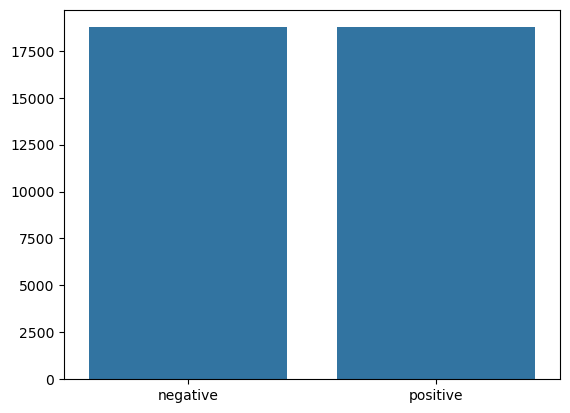

In [5]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Preprocessing the data
* preprocess_string is used to remove the punctuations, extra spaces and digits.
* Iteration over the training data is done.
    * Converting it to lowercase.
    * Removing stopwords like is,the,and
    * Word frequency using counter. 
    * Keeps only 1000 common words
    * creates one-hot encoding.
* Converts x_train and x_test to corresponding one-hot encoding. Filters out words 
* encoding labels

In [6]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s
def tokenize(x_train,y_train,x_val,y_val):
    word_list = []
    # Stop words contain is, the, and
    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            # Remove all non-words characters
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
    # Counter includes word frequency in the context
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train,dtype=object), np.array(encoded_train,dtype=object),np.array(final_list_test,dtype=object), np.array(encoded_test,dtype=object),onehot_dict

In [7]:
X_train,y_train,X_test,y_test,vocab = tokenize(X_train,y_train,X_test,y_test)
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


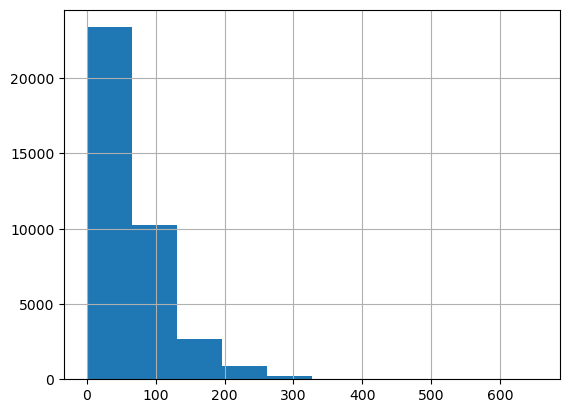

count    37500.000000
mean        69.428693
std         48.293686
min          0.000000
25%         39.000000
50%         54.000000
75%         85.000000
max        654.000000
dtype: float64

In [8]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [9]:
# Add a padding and convert the dataset to tensor format
def padding_tensor(X,y,length):
    # features = np.zeros((len(X), length),dtype=int)
    # for ii, review in enumerate(X):
    #     if len(review) != 0:
    #         features[ii, -len(review):] = np.array(review)[:length]
    # data = TensorDataset(torch.from_numpy(features), torch.from_numpy(y))

    # Convert X to a padded numpy array (ensures fixed shape)
    X_padded = pad_sequences(X, maxlen=length, padding='post', truncating='post', dtype='int32')
    y = np.array(y, dtype=np.int64)

    # Convert to PyTorch tensors (ensuring correct dtype)
    features = torch.tensor(X_padded, dtype=torch.int64)
    labels = torch.tensor(y, dtype=torch.int64)

    # Create TensorDataset
    data = TensorDataset(features, labels)
    return data

In [10]:
Train_data = padding_tensor(X_train,y_train,500)
Test_data = padding_tensor(X_test,y_test,500)
# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
Train_data = DataLoader(Train_data, shuffle=True, batch_size=batch_size)
Test_data = DataLoader(Test_data, shuffle=True, batch_size=batch_size)

### LSTM Model
* Long short term memory helps the NN to store the informative context and forget the stuff which is not required.
* LSTM is type of Recurrent Neural Network. RNN iteratively runs through the model letter by letter by passing as input and the output is given as an input and checked with the data set to correct the error.
* The issue with RNN is Long term dependency problem. When more an more information is piled up with more time. RNN faces difficulty with training and understanding.
* LSTM rectifies the problem by adding the state module to the RNN. When the input to output is provided with RNN. The state information is also given as input.
* LSTM cell has three gate:
    * Forget gate: Forget gate enables the state where the information can be forgotten.
    * I/O gate: What new information can be added and updated to the information in an model. 
    * O/P gate: Based on the whole information, which part needs to be output of the cell.
    * it is b/w the range of 0 and 1. based on which the information is passed inside the gate. 0 meaning no information is passed.
    

In [13]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedded_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim =hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        self.embedding  = nn.Embedding(vocab_size,embedded_dim)

        self.lstm = nn.LSTM(input_size=embedded_dim,hidden_size=self.hidden_dim,num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(self.hidden_dim,output_dim)
        self.sig = nn.Sigmoid()
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out,hidden = self.lstm(embeds,hidden)
        lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # return last sigmoid out
        return sig_out,hidden
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
        



In [14]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)
